December 18, 2024

Goal: Determine the scaling of the circuit size and depth w.r.t. the no. of qubits for different scalable benchmarks from mqtbench.

In [1]:
cd ..

/home/abhishekabhishek/git/cpsc-513-project


First, let's verify that `mqtbench` is setup and let's explore a VQE circuit:

In [2]:
from mqt.bench import get_benchmark

In [3]:
# setup the backend to transpile
from keys import IBMQ_API
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", token=IBMQ_API, instance="ibm-q/open/main")
ibm_backend = service.backend("ibm_sherbrooke")

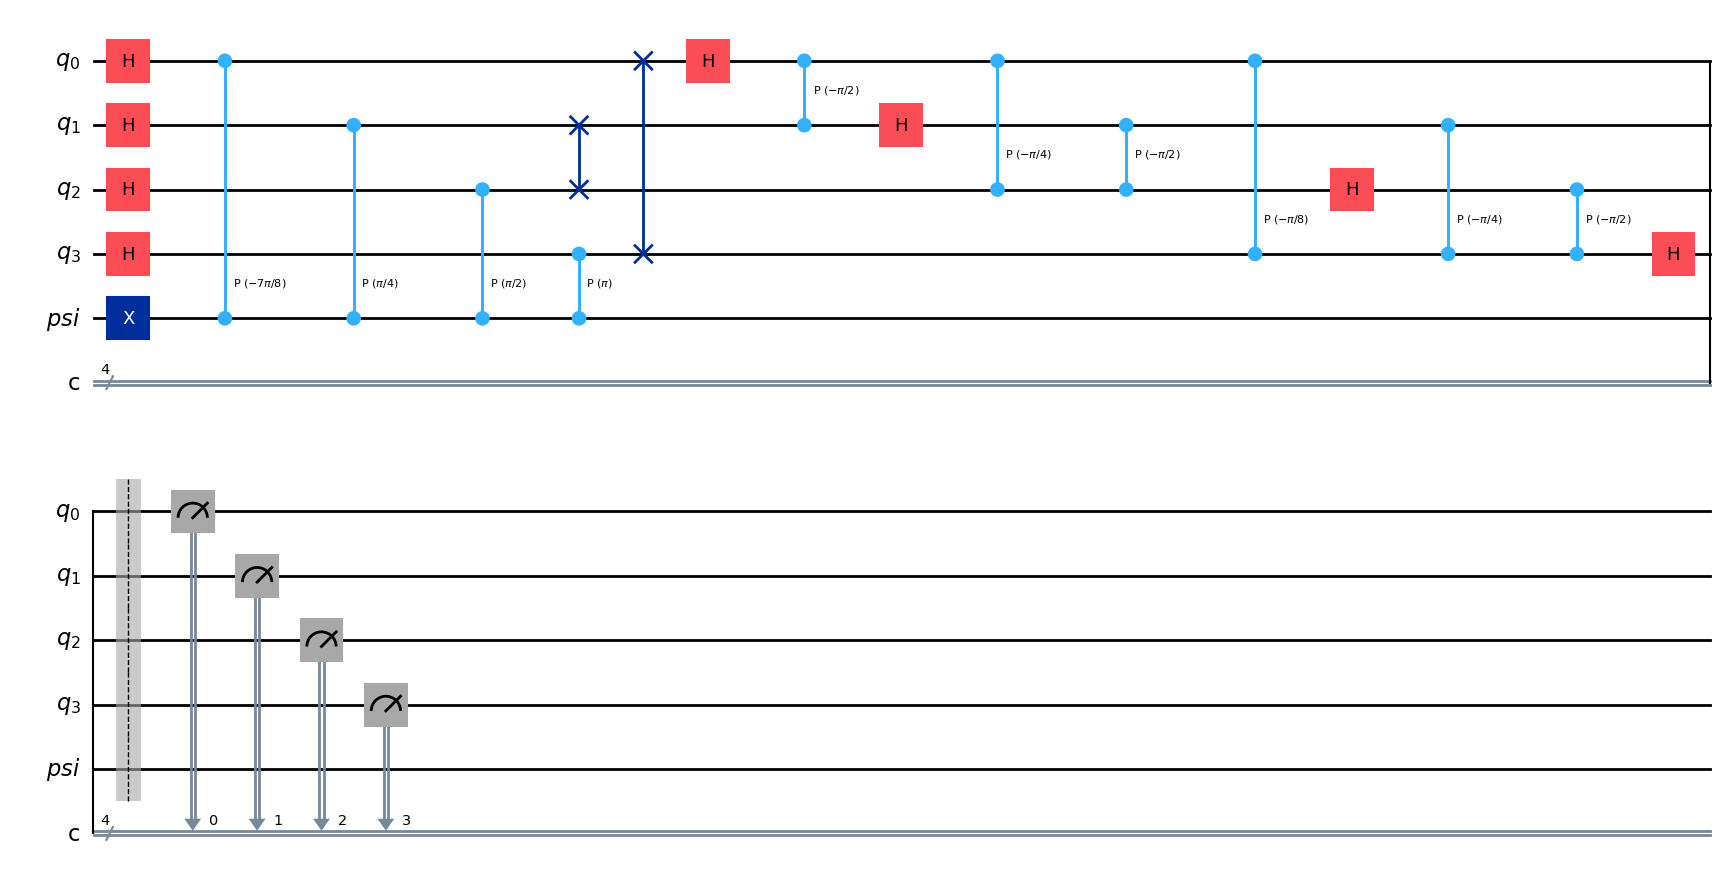

In [4]:
qc = get_benchmark('qpeexact', level='indep', circuit_size=5)
qc.draw(output='mpl')

Let's transpile this circuit to `ibm_sherbrooke` and verify equivalence:

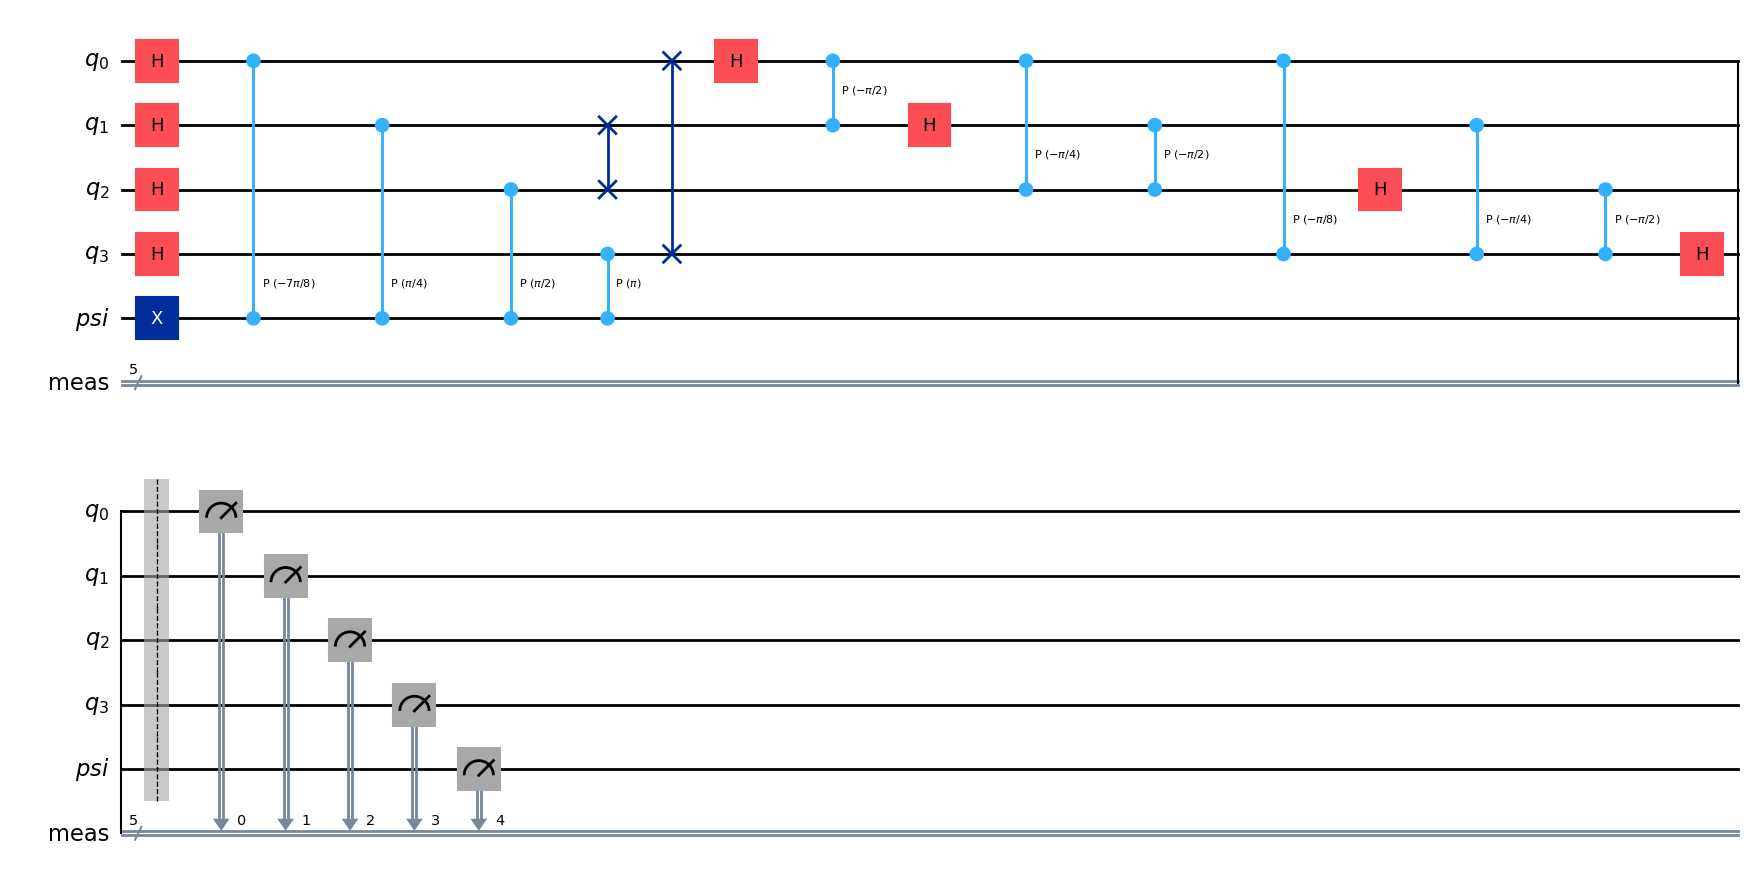

In [6]:
from qiskit import QuantumCircuit, transpile

# important to measure all the qubits before transpiling
# however, since there can already be measurements in the circuit, first we remove them and then
# apply measure_all()
qc.remove_final_measurements()
qc.measure_all()

qc_hw = transpile(qc, ibm_backend)
qc.draw(output='mpl')

In [7]:
config_dict = {
        # application
        "alternating_scheme": "proportional",
        "simulation_scheme": "proportional",

        # execution
        "run_zx_checker": False,
        # TODO(abhi) set this if need to use internal qcec timeout (note this does not always work!)
        # "timeout": 60.,

        # functionality
        "check_partial_equivalence": False,

        # optimizations
        "elide_permutations": False,
        "fuse_single_qubit_gates": False,
        "reconstruct_swaps": False,
        "reorder_operations": False,
        "transform_dynamic_circuit": False,

        # simulation
}

In [8]:
from mqt import qcec
from mqt.qcec import Configuration
from mqt.qcec.configuration import augment_config_from_kwargs

In [9]:
# update the configuration with the dictionary
config = Configuration()
augment_config_from_kwargs(config, config_dict)

In [10]:
result = qcec.verify(qc, qc_hw, config)

Ahhh... shoot. Here comes the problems...

In [11]:
qc.count_ops()

OrderedDict([('cp', 10),
             ('h', 8),
             ('measure', 5),
             ('swap', 2),
             ('x', 1),
             ('barrier', 1)])

In [12]:
qc_hw.count_ops()

OrderedDict([('rz', 77),
             ('sx', 40),
             ('ecr', 27),
             ('x', 9),
             ('measure', 5),
             ('barrier', 1)])

Check the result:

In [13]:
result

<EquivalenceCheckingManager.Results: equivalent_up_to_global_phase>

Ok. Thankfully, we get the correct result from the eq. checker. Now, let's characterize the circuts as we increase the no. of qubits:

In [17]:
# let's use the same techique as before - update a dict and create the df from the resulting dict
circ_info_dict = {
    'gate_set': [],
    'n_gates_original': [],
    'n_gates_transpiled': [],
    'depth_original': [],
    'depth_transpiled': [],
    'n_qubits_original': [],
    'n_qubits_transpiled': [],
    'n_ancilla_original': [],
    'n_ancilla_transpiled': []
}

min_qubits, max_qubits = 5, 100
qubit_step_size = 5
benchmark_name = 'qpeexact'

for n_qubits in range(min_qubits, max_qubits+1, qubit_step_size):
    circ = get_benchmark(benchmark_name, level='indep', circuit_size=n_qubits)
    
    # remove end-of-circuit measurements and add to all qubits
    circ.remove_final_measurements()
    circ.measure_all()

    # get the metrics from the original "uncompiled" circuit
    circ_op_dict = circ.count_ops()
    circ_info_dict['gate_set'].append('_'.join(list(circ_op_dict.keys())))
    
    circ_info_dict['n_qubits_original'].append(circ.num_qubits)
    circ_info_dict['n_gates_original'].append(sum(circ_op_dict.values()))
    circ_info_dict['depth_original'].append(circ.depth())
    circ_info_dict['n_ancilla_original'].append(circ.num_ancillas)
    
    # transpile the circuit to the IBM backend (ibm_sherbrooke) and get the metrics from the
    # transpiled circuit
    circ_hw = transpile(circ, ibm_backend)
    
    circ_hw_op_dict = circ_hw.count_ops()
    circ_info_dict['n_qubits_transpiled'].append(circ_hw.num_qubits)
    circ_info_dict['n_gates_transpiled'].append(sum(circ_hw_op_dict.values()))
    circ_info_dict['depth_transpiled'].append(circ_hw.depth())
    circ_info_dict['n_ancilla_transpiled'].append(circ_hw.num_ancillas)

In [18]:
import pandas as pd
circ_info_df = pd.DataFrame.from_dict(circ_info_dict)
circ_info_df

,gate_set,n_gates_original,n_gates_transpiled,depth_original,depth_transpiled,n_qubits_original,n_qubits_transpiled,n_ancilla_original,n_ancilla_transpiled
0,cp_h_measure_swap_x_barrier,27,185,14,128,5,127,0,0
1,cp_h_measure_swap_x_barrier,77,1063,25,476,10,127,0,0
2,cp_h_measure_swap_x_barrier,157,2403,44,897,15,127,0,0
3,cp_h_measure_swap_x_barrier,259,4741,59,1499,20,127,0,0
4,cp_h_measure_swap_x_barrier,383,7331,66,1616,25,127,0,0
5,cp_h_measure_swap_x_barrier,538,12346,87,2644,30,127,0,0
6,cp_h_measure_swap_x_barrier,717,16697,104,3666,35,127,0,0
7,cp_h_measure_swap_x_barrier,919,21146,119,4251,40,127,0,0
8,cp_h_measure_swap_x_barrier,1147,24664,134,3613,45,127,0,0
9,cp_h_measure_swap_x_barrier,1399,28249,149,5589,50,127,0,0


We can remove the redundant columns from the df

In [19]:
drop_columns = ['gate_set', 'n_qubits_transpiled', 'n_ancilla_original', 'n_ancilla_transpiled']
circ_info_df = circ_info_df.drop(drop_columns, axis=1)
circ_info_df

,n_gates_original,n_gates_transpiled,depth_original,depth_transpiled,n_qubits_original
0,27,185,14,128,5
1,77,1063,25,476,10
2,157,2403,44,897,15
3,259,4741,59,1499,20
4,383,7331,66,1616,25
5,538,12346,87,2644,30
6,717,16697,104,3666,35
7,919,21146,119,4251,40
8,1147,24664,134,3613,45
9,1399,28249,149,5589,50


In [ ]:
min_qubits, max_qubits = 5, 100
qubit_step_size = 5